# MENNPDF with 2D examples

This notebook illustrates the usage of the MENNPDF method over some examples.

## Configuration

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.stats as st
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm, colors

from mennpdf_multivariate import gaussianKdeInt, SimpleMultiMaxEntrLayer, SimpleMultiMaxEntrModel
from ressources.mmd_tools import rbfDot, sigmaCalc, mmd2u, mmd2uEigValSample, pValueCalc
from ressources.custom_distributions import spiralPDF

import sys
sys.path.append('path/to/deep-kexpfam/')
from Datasets import *

2025-03-20 15:36:00.952775: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 15:36:00.982006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 15:36:01.419165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2025-03-20 15:36:02.695114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-20 15:36:02.718952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-20 15:36:02.719257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Selection of the distribution in Wenliang19a datasets:

In [3]:
n = 1000
testName = "multiring"

distr = load_data(testName, D=2, seed=None, itanh=False)
sample = 1. * distr.data[:n, :].T               # Allows scaling of the sample

Illustration of the training sample

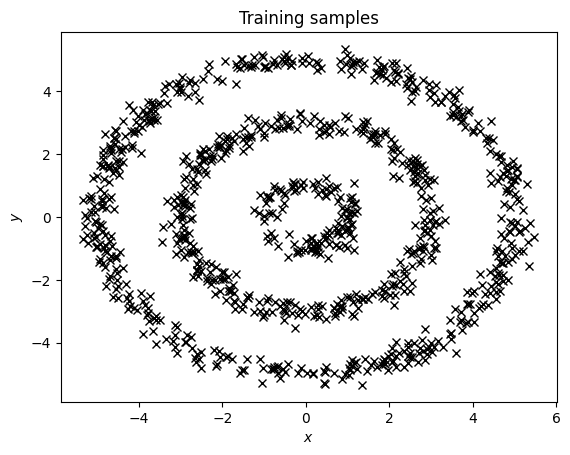

In [4]:
plt.figure(num=1, clear=True)
plt.plot(sample[0, :], sample[1, :], 'xk')
plt.title("Training samples")
plt.xlabel(r"$x$")
_ = plt.ylabel(r"$y$")

Using a Gaussian KDE to generate the integration data with associated weights.

In [5]:
blurryBandwidth, nbInt = .5, 2**17

intPts, intWeights = gaussianKdeInt(nbInt, sample, blurryBandwidth)

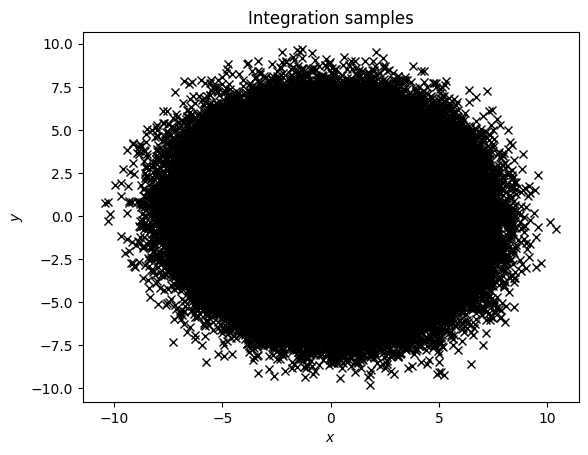

In [6]:
plt.figure(num=2, clear=True)
plt.plot(intPts[0, :], intPts[1, :], 'xk')
plt.title("Integration samples")
plt.xlabel(r"$x$")
_ = plt.ylabel(r"$y$")

Definition of the neural network and the model

In [7]:
gNN = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.GaussianNoise(0.02),
    tf.keras.layers.Dense(40, activation='swish'),
    tf.keras.layers.Dense(20, activation='swish'),
    tf.keras.layers.Dense(10, activation='swish'),
    tf.keras.layers.Dense(1, activation='linear')
])

MElay = SimpleMultiMaxEntrLayer(intPts.astype(np.float32).T, intWeights[:, None].astype(np.float32))
MEmod = SimpleMultiMaxEntrModel(gNN, MElay)

In [8]:
gNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,161 (4.54 KB)

 Trainable params: 1,161 (4.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
MEmod.compile(optimizer=tf.optimizers.Adam(15e-4))
countedEpochs = 0
hist = None
MEmod.run_eagerly = False
# MEmod.run_eagerly = True

**Training**

In [10]:
epochsToDo = 10000
histKeras = MEmod.fit(x=sample.T, y=None, batch_size=n, epochs=epochsToDo+countedEpochs , initial_epoch=countedEpochs, verbose=0)
countedEpochs += epochsToDo
if hist == None:
    hist = histKeras.history
else:
    {hist[k].extend(v) for k, v in histKeras.history.items()}

I0000 00:00:1742481365.051110 1400567 service.cc:145] XLA service 0x77c48c00a2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742481365.051139 1400567 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-20 15:36:05.069585: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-20 15:36:05.177586: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-03-20 15:36:06.056345: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

The loss has no direct interpretation.
We plot the evolution of the loss compared to the minimal value in log-scale to visualize its descent.

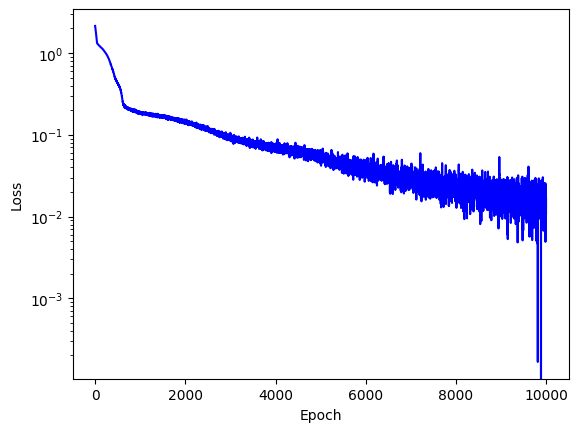

In [11]:
arrHist = np.array(hist['gamma'])
plt.figure(num=3, clear=True)
plt.plot(arrHist - arrHist.min(), '-b')
plt.yscale('log')
plt.xlabel('Epoch')
_ = plt.ylabel('Loss')

## Results

Generation of a sample with the estimated PDF

In [12]:
sigma = sigmaCalc(sample, sample).astype(np.float32)
nbSamps = 10
trySamps = [MEmod.rvs(n, sample.T, 100, sigma).numpy().T for _ in range(nbSamps)]


Comparison between the PDF of the distribution used to generate the sample and the estimated PDF over that sample.

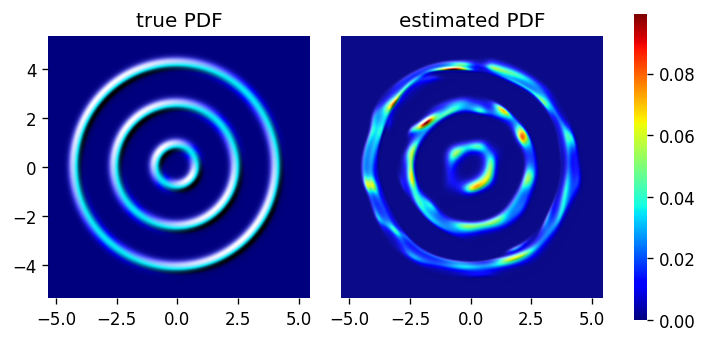

In [13]:
selectedId = 1
tmpSamp = np.concatenate([sample, trySamps[selectedId]], 1)
boxSamp = np.stack([tmpSamp.min(1), tmpSamp.max(1)])
slackSamp = 0.05 * np.array([[-1.], [1.]]) @ (boxSamp[1:2, :] - boxSamp[0:1, :])
boxSamp += slackSamp
del tmpSamp, slackSamp

minSample, maxSample = sample.min(1), sample.max(1)

resGrid = 400
grid = np.stack(np.meshgrid(np.linspace(1.2 * minSample[0], 1.2 * maxSample[0], resGrid), np.linspace(1.2 * minSample[1], 1.2 * maxSample[1], resGrid)), axis=-1).reshape((resGrid**2,2))

estVal = MEmod(grid)
if testName != 'spiral':
    refVal = np.exp(distr.logpdf_multiple(grid))
else:
    refVal = spiralPDF(grid.T)

refVal, estVal = np.reshape(refVal, (resGrid, resGrid)), np.reshape(estVal, (resGrid, resGrid))
vmin, vmax = 0., np.nanmax([np.nanmax(refVal), np.nanmax(estVal)])

cMap = plt.cm.jet

lightS = colors.LightSource(azdeg=225, altdeg=45)
estShaded = lightS.shade(estVal, cmap=cMap, blend_mode='hsv', vert_exag=.01, vmin=vmin, vmax=vmax)
trueShaded = lightS.shade(refVal, cmap=cMap, blend_mode='hsv', vert_exag=.01, vmin=vmin, vmax=vmax)

widRatio = [20, 20, 1]
fig, axs = plt.subplots(1, 3, figsize=(6, 3), width_ratios=widRatio, num=4, clear=True, dpi=120)
fig.set_tight_layout(True)

for ax in axs:
    for side in ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set_visible(False)

im1 = axs[0].imshow(trueShaded, extent=(minSample[0], maxSample[0], minSample[1], maxSample[1]), origin='lower', aspect='auto')
axs[0].set_box_aspect(1)
axs[0].set_title('true PDF')

im2 = axs[1].imshow(estShaded, extent=(minSample[0], maxSample[0], minSample[1], maxSample[1]), origin='lower', aspect='auto')
axs[1].set_box_aspect(1)
axs[1].set_title('estimated PDF')

for tick in axs[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)

fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin, vmax), cmap=plt.cm.jet), cax=axs[2])
_ = axs[2].set_frame_on(False)

Assessing the result with the MMD<sub>u</sub><sup>2</sup> metric

In [14]:
pVals = []
for trySamp in trySamps:
    idMax = min(sample.shape[0], trySamp.shape[0])
    MMD2u = mmd2u(sample[:idMax, :], trySamp[:idMax, :], sigma=sigma)
    bsSamp = mmd2uEigValSample(sample[:idMax, :], trySamp[:idMax, :], sigma, nbSamp=10000)
    pValue = pValueCalc(bsSamp, MMD2u)
    pVals.append(pValue)
pVals = np.array(pVals)

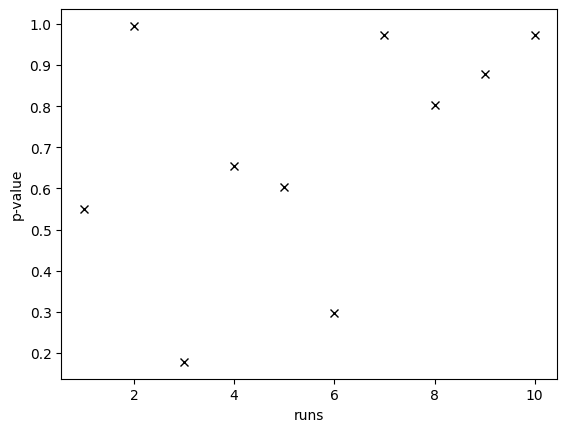

In [15]:
plt.figure(num=5, clear=True)
runs = np.arange(1, pVals.shape[0]+1)
plt.plot(runs, pVals, 'xk')
plt.xlabel("runs")
_ = plt.ylabel("p-value")

Counting the runs with p-values above the 5% threshold.

In [16]:
(pVals >= .05).mean()

1.0

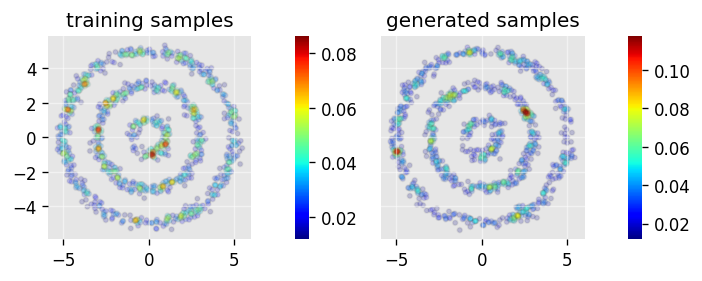

In [ ]:
selectedId = 1
trySamp = trySamps[selectedId]

tmpSamp = np.concatenate([sample, trySamp], 1)
boxSamp = np.stack([tmpSamp.min(1), tmpSamp.max(1)])
slackSamp = 0.05 * np.array([[-1.], [1.]]) @ (boxSamp[1:2, :] - boxSamp[0:1, :])
boxSamp += slackSamp
del tmpSamp, slackSamp

figSamp, axs = plt.subplots(1, 4, figsize=(7, 2.2), width_ratios=[20, 1]*2, gridspec_kw={"wspace":0.1}, num=6, clear=True, dpi=120)

binsFig = 100

bwFig = (boxSamp.ptp(0)/binsFig/sample.std(1)).min()

sampList = st.gaussian_kde(sample, bw_method=bwFig).pdf(sample)
tryList = st.gaussian_kde(trySamp, bw_method=bwFig).pdf(trySamp)

indSampSort, indTrySort = sampList.argsort(), tryList.argsort()

sampNorm = Normalize(vmin=sampList[indSampSort[0]],vmax=sampList[indSampSort[-1]])
tryNorm = Normalize(vmin=tryList[indTrySort[0]],vmax=tryList[indTrySort[-1]])

xSamp, ySamp, sampList = sample[0, :][indSampSort], sample[1, :][indSampSort], sampNorm(sampList[indSampSort])
xTry, yTry, tryList = trySamp[0, :][indTrySort], trySamp[1, :][indTrySort], tryNorm(tryList[indTrySort])

cMap = plt.cm.jet


axs[0].set_title('training samples')
axs[2].set_title('generated samples')

axs[0].scatter(xSamp, ySamp, c=cMap(sampList, alpha=.2), marker='.', edgecolor='#00000010', rasterized=True)
axs[2].scatter(xTry, yTry, c=cMap(tryList, alpha=.2), marker='.', edgecolor='#00000010', rasterized=True)
axs[0].set_xlim(*boxSamp[:, 0])
axs[2].set_xlim(*boxSamp[:, 0])
axs[0].set_ylim(*boxSamp[:, 1])
axs[2].set_ylim(*boxSamp[:, 1])
axs[0].set_xbound(*boxSamp[:, 0])
axs[2].set_xbound(*boxSamp[:, 0])
axs[0].set_ybound(*boxSamp[:, 1])
axs[2].set_ybound(*boxSamp[:, 1])

figSamp.colorbar(plt.cm.ScalarMappable(sampNorm, cMap), cax=axs[1])
figSamp.colorbar(plt.cm.ScalarMappable(tryNorm, cMap), cax=axs[3])


for i, ax in enumerate(axs):
    for side in ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set_visible(False)
    if  i % 2 == 0:   
        ax.grid(True, axis='both', color='w', alpha=.5)
        ax.set_facecolor('0.9')
        ax.set_box_aspect(1)
    else:
           ax.set_frame_on(False)
           box = ax.get_position()
           box.x0, box.x1 = box.x0 - (box.x1 - box.x0), box.x0
           ax.set_position(box)
for tick in axs[2].yaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)
